In [1]:

import warnings
warnings.filterwarnings("ignore")

In [2]:
pip install xgboost


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn.neighbors import NearestNeighbors

In [4]:
# data cleaning and plots
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# sklearn: data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# sklearn: train model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

# sklearn classifiers

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn import datasets, ensemble, model_selection
from sklearn.ensemble import RandomForestClassifier

from sklearn.neural_network import MLPClassifier

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



In [6]:
# Load data
df = pd.read_csv(r'H:\python\explainable AI\archive\cicds2023.csv', engine = 'python')

In [7]:
print(df)

        flow_duration  Header_Length  Protocol Type  Duration         Rate  \
0            0.000000           2.06          46.59     63.78     1.397840   
1            0.000000          54.00           6.00     64.00     2.130290   
2            0.007771           3.30          42.14     82.46     7.248154   
3            0.327774          96.06           6.00     64.00     4.346313   
4            0.100559       42845.28          16.78     65.91  8829.262382   
...               ...            ...            ...       ...          ...   
240041       0.011324          33.52           1.38     62.21    30.468957   
240042       0.124466       40434.00          16.83     63.36  7622.399807   
240043       0.022697          66.84           6.22     66.55     1.131130   
240044       0.000000           0.00           1.00     64.00    18.243148   
240045       1.397100         113.94           6.00     64.00     2.344105   

              Srate  Drate  fin_flag_number  syn_flag_number  r

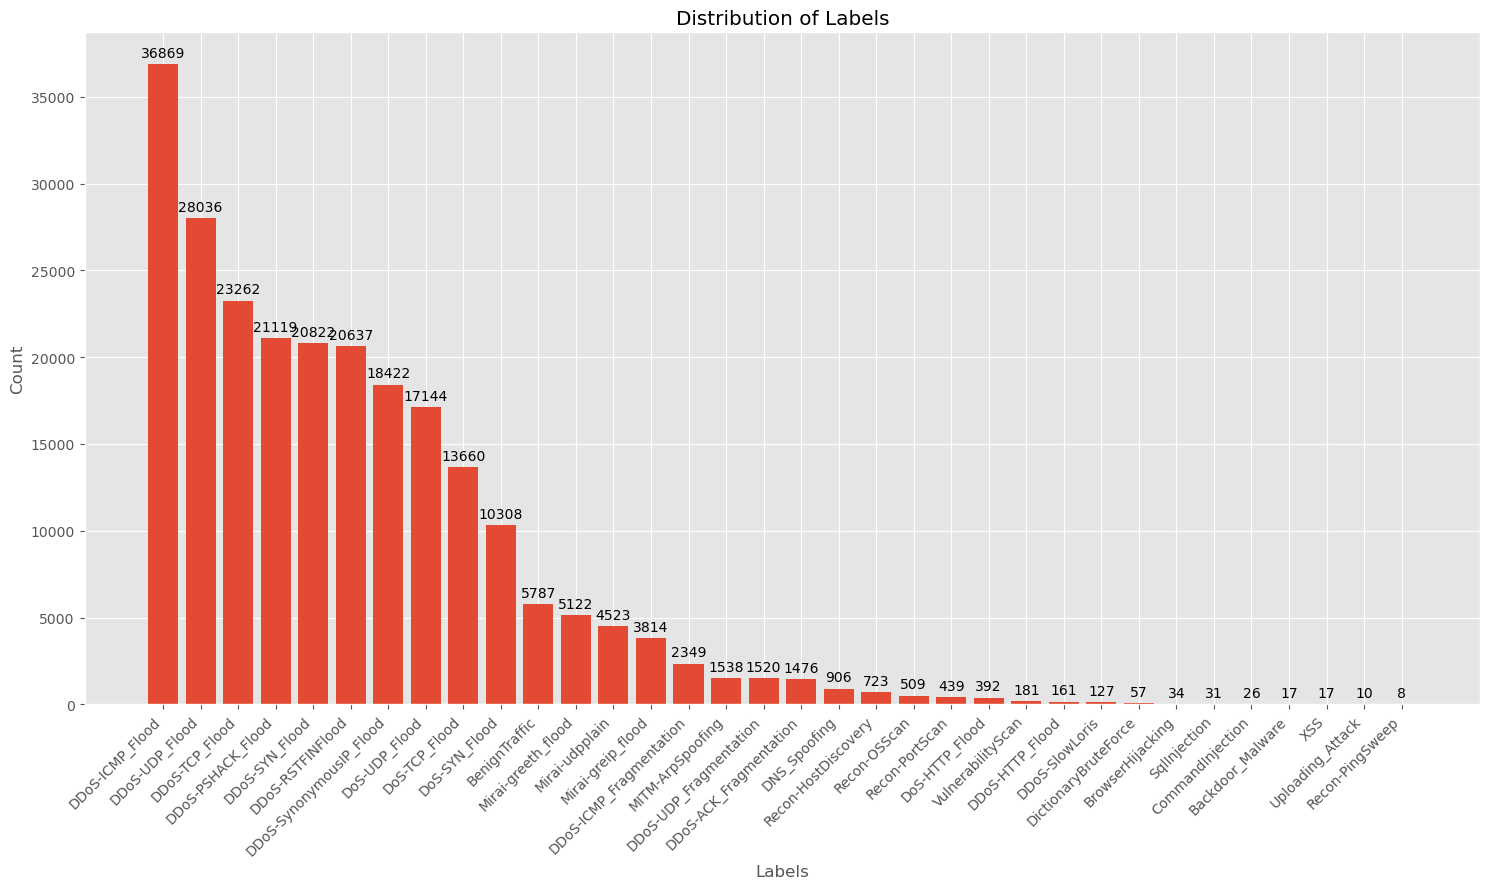

In [8]:
# Create graph column
fig, ax = plt.subplots(figsize=(15, 9))
bars = ax.bar(df["label"].value_counts().index, df["label"].value_counts().values, width=0.8)

# Rotate the label on the x-axis
ax.set_xticklabels(df["label"].value_counts().index, rotation=45, ha='right')

# Format the number on the y axis
ax.yaxis.set_major_formatter('{:.0f}'.format)

# Add labels and titles
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.set_title('Distribution of Labels')

# Show exact figures at the top of each column
for bar in bars:
    height = bar.get_height()
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

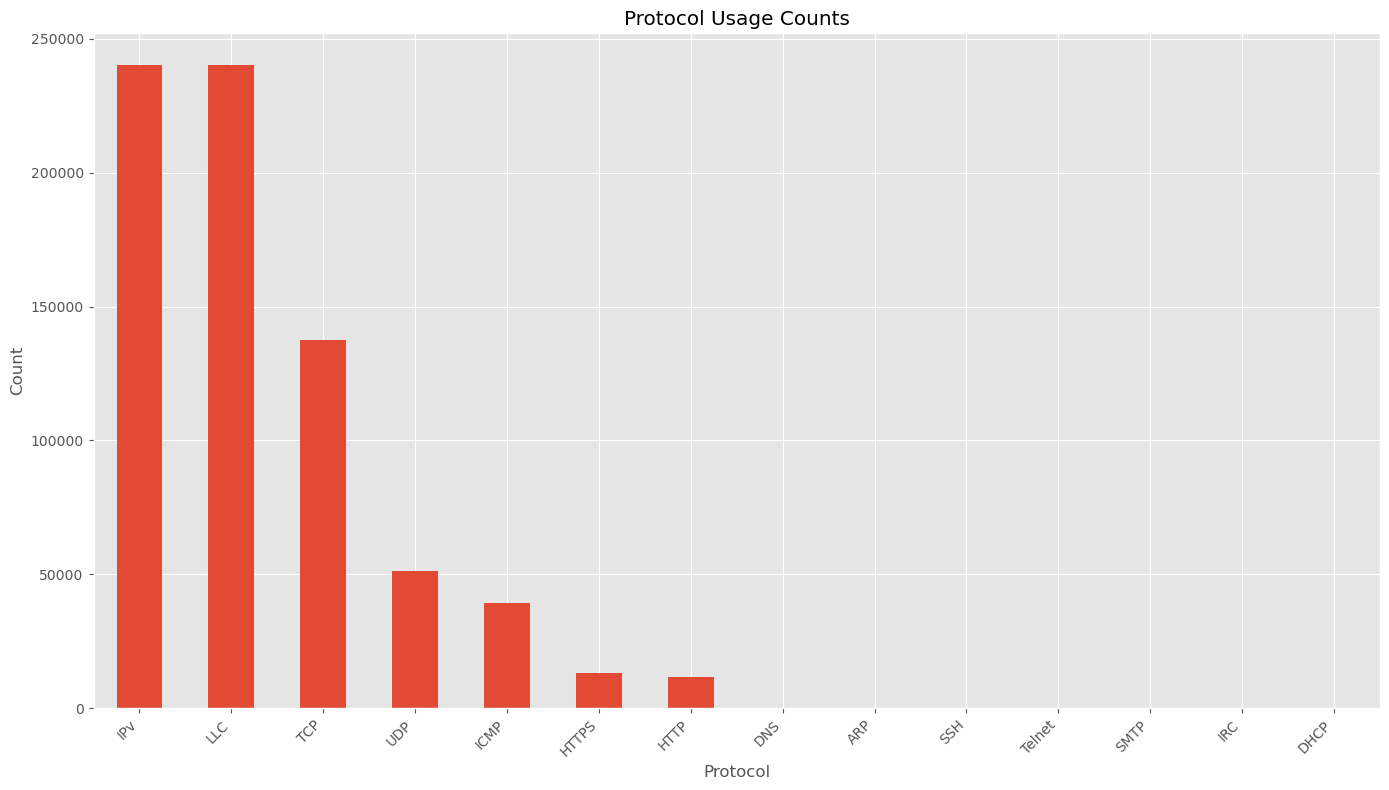

In [9]:
protocols = ['HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC']
protocol_counts = df[protocols].sum().sort_values(ascending=False)
# Now let's plot the protocol usage
plt.figure(figsize=(14, 8))
protocol_counts.plot(kind='bar')
plt.title('Protocol Usage Counts')
plt.xlabel('Protocol')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better fit
plt.tight_layout()  # Adjust layout
plt.show()


In [10]:
# Min-max normalization
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x - x.min()) / (x.max()-x.min()))
# Fill empty values by 0
df = df.fillna(0)

In [11]:
print(df)

        flow_duration  Header_Length  Protocol Type  Duration          Rate  \
0        0.000000e+00   2.116293e-07       0.991164  0.244190  2.221807e-07   
1        0.000000e+00   5.547564e-06       0.116379  0.245059  3.386005e-07   
2        1.306996e-07   3.390178e-07       0.895259  0.318024  1.152063e-06   
3        5.513118e-06   9.868499e-06       0.116379  0.245059  6.908279e-07   
4        1.691395e-06   4.401609e-03       0.348707  0.252609  1.403373e-03   
...               ...            ...            ...       ...           ...   
240041   1.904757e-07   3.443599e-06       0.016810  0.237984  4.842910e-06   
240042   2.093500e-06   4.153892e-03       0.349784  0.242530  1.211548e-03   
240043   3.817563e-07   6.866651e-06       0.121121  0.255138  1.797882e-07   
240044   0.000000e+00   0.000000e+00       0.008621  0.245059  2.899670e-06   
240045   2.349903e-05   1.170536e-05       0.116379  0.245059  3.725855e-07   

               Srate  Drate  fin_flag_number  syn_f

In [12]:
 mapping = {'BenignTraffic': 0, 'DDoS-ICMP_Flood': 1, 'DDoS-UDP_Flood': 1, 'DDoS-TCP_Flood': 1, 'DDoS-PSHACK_Flood': 1, 'DDoS-SYN_Flood': 1, 'DDoS-RSTFINFlood': 1, 'DDoS-SynonymousIP_Flood': 1, 'DDoS-ICMP_Fragmentation': 1, 'DDoS-UDP_Fragmentation': 1, 'DDoS-ACK_Fragmentation': 1, 'DDoS-HTTP_Flood': 1, 'DDoS-SlowLoris': 1 ,'DoS-UDP_Flood': 1, 'DoS-TCP_Flood': 1, 'DoS-SYN_Flood': 1, 'DoS-HTTP_Flood': 1, 'Recon-HostDiscovery': 1, 'Recon-OSScan': 1, 'Recon-PortScan': 1, 'Recon-PingSweep': 1, 'VulnerabilityScan': 1, 'MITM-ArpSpoofing': 1, 'DNS_Spoofing': 1, 'DictionaryBruteForce': 1, 'BrowserHijacking': 1, 'XSS': 1, 'Uploading_Attack': 1, 'SqlInjection': 1, 'CommandInjection': 1, 'Backdoor_Malware': 1, 'Mirai-greeth_flood': 1, 'Mirai-udpplain': 1, 'Mirai-greip_flood': 1,  }

# Map string values to numeric values using dictionary
df['label'] = df['label'].map(mapping)

print(df)



        flow_duration  Header_Length  Protocol Type  Duration          Rate  \
0        0.000000e+00   2.116293e-07       0.991164  0.244190  2.221807e-07   
1        0.000000e+00   5.547564e-06       0.116379  0.245059  3.386005e-07   
2        1.306996e-07   3.390178e-07       0.895259  0.318024  1.152063e-06   
3        5.513118e-06   9.868499e-06       0.116379  0.245059  6.908279e-07   
4        1.691395e-06   4.401609e-03       0.348707  0.252609  1.403373e-03   
...               ...            ...            ...       ...           ...   
240041   1.904757e-07   3.443599e-06       0.016810  0.237984  4.842910e-06   
240042   2.093500e-06   4.153892e-03       0.349784  0.242530  1.211548e-03   
240043   3.817563e-07   6.866651e-06       0.121121  0.255138  1.797882e-07   
240044   0.000000e+00   0.000000e+00       0.008621  0.245059  2.899670e-06   
240045   2.349903e-05   1.170536e-05       0.116379  0.245059  3.725855e-07   

               Srate  Drate  fin_flag_number  syn_f

In [13]:
# Separate features (X) and target variable (y)
X = df.drop(columns=["label"])  # Replace "target_column_name" with the name of your target column
y = df["label"]

In [14]:

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)





In [15]:
df.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000e+00,2.116293e-07,0.991164,0.244190,2.221807e-07,2.221807e-07,0.0,0.0,0.0,0.0,...,0.000141,0.093903,0.499150,0.68,0.254798,0.000000,0.000000e+00,0.00,0.57697,1
1,0.000000e+00,5.547564e-06,0.116379,0.245059,3.386005e-07,3.386005e-07,0.0,0.0,0.0,0.0,...,0.000000,0.002063,0.497090,0.68,0.012386,0.000000,0.000000e+00,0.00,0.57697,1
2,1.306996e-07,3.390178e-07,0.895259,0.318024,1.152063e-06,1.152063e-06,0.0,0.0,0.0,0.0,...,0.014192,0.082761,0.498996,0.68,0.222825,0.014184,4.946727e-04,0.40,0.57697,1
3,5.513118e-06,9.868499e-06,0.116379,0.245059,6.908279e-07,6.908279e-07,0.0,0.0,0.0,1.0,...,0.000052,0.002146,0.494946,0.68,0.012806,0.000052,1.484478e-08,0.17,0.57697,1
4,1.691395e-06,4.401609e-03,0.348707,0.252609,1.403373e-03,1.403373e-03,0.0,0.0,0.0,0.0,...,0.000162,0.001874,0.495209,0.68,0.008573,0.000068,5.394445e-08,0.08,0.57697,1


In [16]:
pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense


In [18]:
pip install keras


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [19]:
print(df)

        flow_duration  Header_Length  Protocol Type  Duration          Rate  \
0        0.000000e+00   2.116293e-07       0.991164  0.244190  2.221807e-07   
1        0.000000e+00   5.547564e-06       0.116379  0.245059  3.386005e-07   
2        1.306996e-07   3.390178e-07       0.895259  0.318024  1.152063e-06   
3        5.513118e-06   9.868499e-06       0.116379  0.245059  6.908279e-07   
4        1.691395e-06   4.401609e-03       0.348707  0.252609  1.403373e-03   
...               ...            ...            ...       ...           ...   
240041   1.904757e-07   3.443599e-06       0.016810  0.237984  4.842910e-06   
240042   2.093500e-06   4.153892e-03       0.349784  0.242530  1.211548e-03   
240043   3.817563e-07   6.866651e-06       0.121121  0.255138  1.797882e-07   
240044   0.000000e+00   0.000000e+00       0.008621  0.245059  2.899670e-06   
240045   2.349903e-05   1.170536e-05       0.116379  0.245059  3.725855e-07   

               Srate  Drate  fin_flag_number  syn_f

In [20]:
import numpy as np
from scipy.stats import mode

# Identify NaN indices
nan_indices = np.isnan(y_train)

# Find mode of non-NaN values
mode_value = mode(y_train[~nan_indices])[0]

# Replace NaN values with mode
y_train[nan_indices] = mode_value

# Check unique values again
print(np.unique(y_train))




[0 1]


In [21]:
# Check for NaN values
print(X_train.isna().sum())
print(X_test.isna().sum())

# Check for infinite values
print(np.isinf(X_train).sum())
print(np.isinf(X_test).sum())

# Optionally, replace or drop NaN/Infinite values
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)


flow_duration      0
Header_Length      0
Protocol Type      0
Duration           0
Rate               0
Srate              0
Drate              0
fin_flag_number    0
syn_flag_number    0
rst_flag_number    0
psh_flag_number    0
ack_flag_number    0
ece_flag_number    0
cwr_flag_number    0
ack_count          0
syn_count          0
fin_count          0
urg_count          0
rst_count          0
HTTP               0
HTTPS              0
DNS                0
Telnet             0
SMTP               0
SSH                0
IRC                0
TCP                0
UDP                0
DHCP               0
ARP                0
ICMP               0
IPv                0
LLC                0
Tot sum            0
Min                0
Max                0
AVG                0
Std                0
Tot size           0
IAT                0
Number             0
Magnitue           0
Radius             0
Covariance         0
Variance           0
Weight             0
dtype: int64
flow_duration      0


In [22]:
print(np.unique(y_train))


[0 1]


In [23]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras import Input, Model
X_train_array = X_train.to_numpy()  # or X_train.values
X_test_array = X_test.to_numpy()    # or X_test.values

# Reshape data to fit CNN input (1D convolution example)
X_train_cnn = X_train_array.reshape((X_train_array.shape[0], X_train_array.shape[1], 1))
X_test_cnn = X_test_array.reshape((X_test_array.shape[0], X_test_array.shape[1], 1))

# Define CNN model
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(20, activation='relu', name='feature_layer'),  # Dense layer with 20 features
    Dense(1, activation='sigmoid')  # Assuming binary classification
])

# Compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Ensure the model has been built by calling it at least once
model.predict(X_train_cnn[:1])

# Extract features from the flatten layer
# Define feature extraction model using the functional API
input_layer = Input(shape=(X_train_cnn.shape[1], 1))
flatten_layer = Flatten(name='flatten')(input_layer)
feature_extractor_model = Model(inputs=input_layer, outputs=flatten_layer)

train_features = feature_extractor_model.predict(X_train_cnn)
test_features = feature_extractor_model.predict(X_test_cnn)

print("Shape of extracted train features:", train_features.shape)
print("Shape of extracted test features:", test_features.shape)


Epoch 1/10
4801/4801 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.9772 - loss: 0.0625 - val_accuracy: 0.9868 - val_loss: 0.0260
Epoch 2/10
4801/4801 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9859 - loss: 0.0266 - val_accuracy: 0.9877 - val_loss: 0.0239
Epoch 3/10
4801/4801 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.9881 - loss: 0.0233 - val_accuracy: 0.9891 - val_loss: 0.0217
Epoch 4/10
4801/4801 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.9887 - loss: 0.0224 - val_accuracy: 0.9897 - val_loss: 0.0213
Epoch 5/10
4801/4801 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.9887 - loss: 0.0218 - val_accuracy: 0.9904 - val_loss: 0.0205
Epoch 6/10
4801/4801 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.9889 - loss: 0.0216 - val_accuracy: 0.9895 - val_loss: 0.0205
Epoch 7/10
4801/4801 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9897 - loss: 0.0202 - val_accuracy: 0.9902 - val_loss: 0.0197
Epoch 8/10
4801/4801 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.9902 - loss: 0

In [24]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from scipy.stats import mode
selected_train_features = train_features
selected_test_features = test_features

# Train SVM classifier
svm = SVC(kernel='linear')
svm.fit(selected_train_features, y_train)

# Evaluate the classifier
y_pred = svm.predict(selected_test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.9870027077692147


In [25]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from joblib import Parallel, delayed

def fitness_function(features, labels, subset):
    if np.sum(subset) != 30:  # Ensure exactly 32 features are selected
        return 0
    selected_features = features[:, subset == 1]
    clf = SVC(kernel='linear')
    scores = cross_val_score(clf, selected_features, labels, cv=5)
    return scores.mean()

def gray_wolf_optimizer(features, labels, population_size=20, max_iter=10, early_stopping_rounds=5):
    num_features = features.shape[1]
    population = np.random.randint(2, size=(population_size, num_features))
    alpha, beta, delta = np.zeros(num_features), np.zeros(num_features), np.zeros(num_features)
    alpha_score, beta_score, delta_score = -np.inf, -np.inf, -np.inf

    no_improvement_counter = 0
    best_score = -np.inf

    for iteration in range(max_iter):
        if no_improvement_counter >= early_stopping_rounds:
            print("Early stopping at iteration", iteration)
            break
        
        a = 2 * (1 - iteration / max_iter)  # Update 'a' outside the inner loop

        fitness_scores = Parallel(n_jobs=-1)(delayed(fitness_function)(features, labels, wolf) for wolf in population)

        for idx, wolf in enumerate(population):
            fitness = fitness_scores[idx]
            if fitness > alpha_score:
                alpha_score, alpha = fitness, wolf.copy()
            elif fitness > beta_score:
                beta_score, beta = fitness, wolf.copy()
            elif fitness > delta_score:
                delta_score, delta = fitness, wolf.copy()

        if alpha_score > best_score:
            best_score = alpha_score
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        for wolf in population:
            for feature in range(num_features):
                r1, r2 = np.random.rand(), np.random.rand()

                A1, C1 = 2 * a * r1 - a, 2 * r2
                D_alpha = np.abs(C1 * alpha[feature] - wolf[feature])
                X1 = alpha[feature] - A1 * D_alpha

                r1, r2 = np.random.rand(), np.random.rand()
                A2, C2 = 2 * a * r1 - a, 2 * r2
                D_beta = np.abs(C2 * beta[feature] - wolf[feature])
                X2 = beta[feature] - A2 * D_beta

                r1, r2 = np.random.rand(), np.random.rand()
                A3, C3 = 2 * a * r1 - a, 2 * r2
                D_delta = np.abs(C3 * delta[feature] - wolf[feature])
                X3 = delta[feature] - A3 * D_delta

                wolf[feature] = (X1 + X2 + X3) / 3

    return alpha

# Example usage
population_size = 20  # Adjust population size
max_iter = 30  # Adjust the number of iterations
early_stopping_rounds = 5  # Early stopping if no improvement over 5 iterations

# Convert NaNs to mode value
mode_value = np.nanmedian(y_train)
y_train = np.nan_to_num(y_train, nan=mode_value)

selected_features = gray_wolf_optimizer(train_features, y_train, population_size=population_size, max_iter=max_iter, early_stopping_rounds=early_stopping_rounds)

# Convert selected_features to a boolean mask
selected_features_mask = selected_features == 1
print("Selected features mask:", selected_features_mask)

# Get the indices of the selected features
selected_feature_indices = np.where(selected_features_mask)[0]

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]
print("Selected feature names:", selected_feature_names.tolist())



Early stopping at iteration 6
Selected features mask: [ True  True False  True False  True False False  True  True False False
  True False False False  True False  True  True  True False False  True
  True  True False False False False  True False False  True  True  True
  True False False  True False False  True  True False False]
Selected feature names: ['flow_duration', 'Header_Length', 'Duration', 'Srate', 'syn_flag_number', 'rst_flag_number', 'ece_flag_number', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'SMTP', 'SSH', 'IRC', 'ICMP', 'Tot sum', 'Min', 'Max', 'AVG', 'IAT', 'Radius', 'Covariance']


Accuracy: 0.9960841491355967
Training Time: 39.472500801086426 seconds
Prediction Time: 0.7532057762145996 seconds
Precision of RF: 0.9961168457555848
Recall of RF: 0.9960841491355967
F1-score of RF: 0.9960991226992547
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1139
           1       1.00      1.00      1.00     46871

    accuracy                           1.00     48010
   macro avg       0.95      0.96      0.96     48010
weighted avg       1.00      1.00      1.00     48010



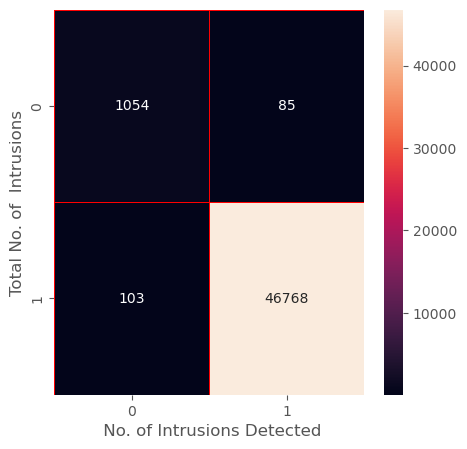

In [26]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

# Select features based on the mask
selected_train_features = train_features[:, selected_features_mask > 0.5]
selected_test_features = test_features[:, selected_features_mask > 0.5]

# Measure the time taken for training the Random Forest classifier
start_time = time.time()
rf = RandomForestClassifier(n_estimators=100)
rf.fit(selected_train_features, y_train)
training_time = time.time() - start_time

# Measure the time taken for prediction
start_time = time.time()
y_pred = rf.predict(selected_test_features)
prediction_time = time.time() - start_time

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Training Time: {training_time} seconds')
print(f'Prediction Time: {prediction_time} seconds')
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
precision,recall,fscore,none= precision_recall_fscore_support(y_test, y_pred, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_test,y_pred))
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel(" No. of Intrusions Detected")
plt.ylabel("Total No. of  Intrusions")
plt.show()


Accuracy: 0.9949802124557384
Training Time: 3.45888614654541 seconds
Prediction Time: 0.07810592651367188 seconds
Precision of XGB: 0.9950914556919046
Recall of XGB: 0.9949802124557384
F1-score of XGB: 0.9950276274384071
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      1139
           1       1.00      1.00      1.00     46871

    accuracy                           0.99     48010
   macro avg       0.94      0.96      0.95     48010
weighted avg       1.00      0.99      1.00     48010



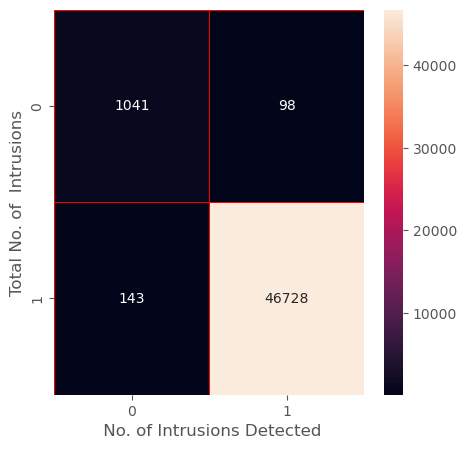

In [27]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score
import time

# Select features based on the mask
selected_train_features = train_features[:, selected_features_mask > 0.5]
selected_test_features = test_features[:, selected_features_mask > 0.5]

# Measure the time taken for training the Random Forest classifier
start_time = time.time()
xgb_classifier = xgb.XGBClassifier(n_estimators=100)
xgb_classifier.fit(selected_train_features, y_train)
training_time = time.time() - start_time

# Measure the time taken for prediction
start_time = time.time()
y_pred = xgb_classifier.predict(selected_test_features)
prediction_time = time.time() - start_time

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Training Time: {training_time} seconds')
print(f'Prediction Time: {prediction_time} seconds')
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
precision,recall,fscore,none= precision_recall_fscore_support(y_test, y_pred, average='weighted')
print('Precision of XGB: '+(str(precision)))
print('Recall of XGB: '+(str(recall)))
print('F1-score of XGB: '+(str(fscore)))
print(classification_report(y_test,y_pred))
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel(" No. of Intrusions Detected")
plt.ylabel("Total No. of  Intrusions")
plt.show()


In [28]:
selected_train_features = train_features[:, selected_features == 1]
selected_test_features = test_features[:, selected_features == 1]

# Train SVM classifier
svm = SVC(kernel='linear')
svm.fit(selected_train_features, y_train)

# Evaluate the classifier
y_pred = svm.predict(selected_test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.985919600083316


In [29]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from joblib import Parallel, delayed

def fitness_function(features, labels, subset):
    if np.sum(subset) != 30:  # Ensure exactly 30 features are selected
        return 0
    selected_features = features[:, subset == 1]
    clf = RandomForestClassifier(n_estimators=100)
    scores = cross_val_score(clf, selected_features, labels, cv=5, n_jobs=-1)
    return scores.mean()

# Example usage (assuming train_features and y_train are defined)
subset = np.random.randint(2, size=train_features.shape[1])  # Random subset for illustration
fitness_value = fitness_function(train_features, y_train, subset)
print(f'Fitness Value: {fitness_value}')

def gray_wolf_optimizer(features, labels, population_size=20, max_iter=10, early_stopping_rounds=5):
    num_features = features.shape[1]
    population = np.random.randint(2, size=(population_size, num_features))
    alpha, beta, delta = np.zeros(num_features), np.zeros(num_features), np.zeros(num_features)
    alpha_score, beta_score, delta_score = -np.inf, -np.inf, -np.inf

    no_improvement_counter = 0
    best_score = -np.inf

    for iteration in range(max_iter):
        if no_improvement_counter >= early_stopping_rounds:
            print("Early stopping at iteration", iteration)
            break
        
        a = 2 * (1 - iteration / max_iter)  # Update 'a' outside the inner loop

        fitness_scores = Parallel(n_jobs=-1)(delayed(fitness_function)(features, labels, wolf) for wolf in population)

        for idx, wolf in enumerate(population):
            fitness = fitness_scores[idx]
            if fitness > alpha_score:
                alpha_score, alpha = fitness, wolf.copy()
            elif fitness > beta_score:
                beta_score, beta = fitness, wolf.copy()
            elif fitness > delta_score:
                delta_score, delta = fitness, wolf.copy()

        if alpha_score > best_score:
            best_score = alpha_score
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        for wolf in population:
            for feature in range(num_features):
                r1, r2 = np.random.rand(), np.random.rand()

                A1, C1 = 2 * a * r1 - a, 2 * r2
                D_alpha = np.abs(C1 * alpha[feature] - wolf[feature])
                X1 = alpha[feature] - A1 * D_alpha

                r1, r2 = np.random.rand(), np.random.rand()
                A2, C2 = 2 * a * r1 - a, 2 * r2
                D_beta = np.abs(C2 * beta[feature] - wolf[feature])
                X2 = beta[feature] - A2 * D_beta

                r1, r2 = np.random.rand(), np.random.rand()
                A3, C3 = 2 * a * r1 - a, 2 * r2
                D_delta = np.abs(C3 * delta[feature] - wolf[feature])
                X3 = delta[feature] - A3 * D_delta

                wolf[feature] = (X1 + X2 + X3) / 3

    return alpha

# Example usage
population_size = 20  # Adjust population size
max_iter = 30  # Adjust the number of iterations
early_stopping_rounds = 5  # Early stopping if no improvement over 5 iterations

# Convert NaNs to mode value
mode_value = np.nanmedian(y_train)
y_train = np.nan_to_num(y_train, nan=mode_value)

selected_features = gray_wolf_optimizer(train_features, y_train, population_size=population_size, max_iter=max_iter, early_stopping_rounds=early_stopping_rounds)

# Convert selected_features to a boolean mask
selected_features_mask = selected_features == 1
print("Selected features mask:", selected_features_mask)

# Get the indices of the selected features
selected_feature_indices = np.where(selected_features_mask)[0]

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]
print("Selected feature names:", selected_feature_names.tolist())



Fitness Value: 0
Early stopping at iteration 6
Selected features mask: [False  True False False  True  True False  True False False False False
  True False False  True  True False False False False  True False  True
  True False False  True False False  True  True  True False False False
 False  True  True  True False  True False  True False  True]
Selected feature names: ['Header_Length', 'Rate', 'Srate', 'fin_flag_number', 'ece_flag_number', 'syn_count', 'fin_count', 'DNS', 'SMTP', 'SSH', 'UDP', 'ICMP', 'IPv', 'LLC', 'Std', 'Tot size', 'IAT', 'Magnitue', 'Covariance', 'Weight']


In [30]:
selected_train_features = train_features[:, selected_features_mask == 1]
selected_test_features = test_features[:, selected_features_mask == 1]

# Train the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(selected_train_features, y_train)

# Evaluate the classifier
y_pred = rf.predict(selected_test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.9954384503228494


In [31]:
import xgboost as xgb

selected_train_features = train_features[:, selected_features_mask == 1]
selected_test_features = test_features[:, selected_features_mask == 1]

# Train the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(n_estimators=100)
xgb_classifier.fit(selected_train_features, y_train)

# Evaluate the classifier
y_pred = xgb_classifier.predict(selected_test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.994230368673193


Accuracy: 0.9952509893772131
Training Time: 30.252145767211914 seconds
Prediction Time: 0.687326192855835 seconds
Precision of RF: 0.9954163139703347
Recall of RF: 0.9952509893772131
F1-score of RF: 0.99531617534289
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1139
           1       1.00      1.00      1.00     46871

    accuracy                           1.00     48010
   macro avg       0.94      0.96      0.95     48010
weighted avg       1.00      1.00      1.00     48010



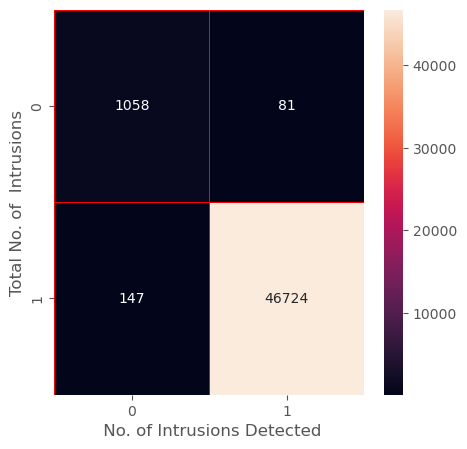

In [32]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

# Select features based on the mask
selected_train_features = train_features[:, selected_features_mask > 0.5]
selected_test_features = test_features[:, selected_features_mask > 0.5]

# Measure the time taken for training the Random Forest classifier
start_time = time.time()
rf = RandomForestClassifier(n_estimators=100)
rf.fit(selected_train_features, y_train)
training_time = time.time() - start_time

# Measure the time taken for prediction
start_time = time.time()
y_pred = rf.predict(selected_test_features)
prediction_time = time.time() - start_time

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Training Time: {training_time} seconds')
print(f'Prediction Time: {prediction_time} seconds')
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
precision,recall,fscore,none= precision_recall_fscore_support(y_test, y_pred, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_test,y_pred))
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel(" No. of Intrusions Detected")
plt.ylabel("Total No. of  Intrusions")
plt.show()


Accuracy: 0.994230368673193
Training Time: 3.1217594146728516 seconds
Prediction Time: 0.07810401916503906 seconds
Precision of XGB: 0.9943805378161649
Recall of XGB: 0.994230368673193
F1-score of XGB: 0.9942943288482172
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1139
           1       1.00      1.00      1.00     46871

    accuracy                           0.99     48010
   macro avg       0.93      0.95      0.94     48010
weighted avg       0.99      0.99      0.99     48010



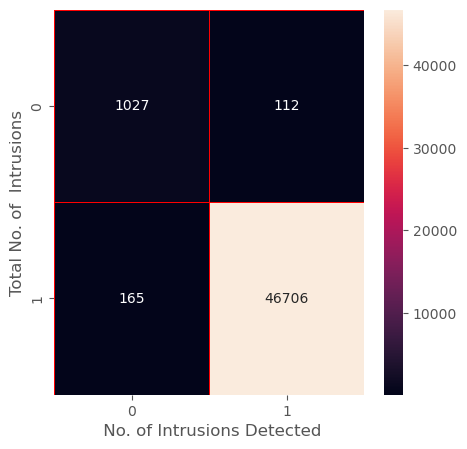

In [33]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score
import time

# Select features based on the mask
selected_train_features = train_features[:, selected_features_mask > 0.5]
selected_test_features = test_features[:, selected_features_mask > 0.5]

# Measure the time taken for training the Random Forest classifier
start_time = time.time()
xgb_classifier = xgb.XGBClassifier(n_estimators=100)
xgb_classifier.fit(selected_train_features, y_train)
training_time = time.time() - start_time

# Measure the time taken for prediction
start_time = time.time()
y_pred = xgb_classifier.predict(selected_test_features)
prediction_time = time.time() - start_time

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Training Time: {training_time} seconds')
print(f'Prediction Time: {prediction_time} seconds')
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
precision,recall,fscore,none= precision_recall_fscore_support(y_test, y_pred, average='weighted')
print('Precision of XGB: '+(str(precision)))
print('Recall of XGB: '+(str(recall)))
print('F1-score of XGB: '+(str(fscore)))
print(classification_report(y_test,y_pred))
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel(" No. of Intrusions Detected")
plt.ylabel("Total No. of  Intrusions")
plt.show()


In [34]:
selected_train_features = train_features[:, selected_features_mask > 0.5]
selected_test_features = test_features[:, selected_features_mask > 0.5]

# Train the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(selected_train_features, y_train)

# Evaluate the classifier
y_pred = rf.predict(selected_test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.9954176213288898


In [35]:
import xgboost as xgb

selected_train_features = train_features[:, selected_features_mask > 0.5]
selected_test_features = test_features[:, selected_features_mask > 0.5]

# Train the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(n_estimators=100)
xgb_classifier.fit(selected_train_features, y_train)

# Evaluate the classifier
y_pred = xgb_classifier.predict(selected_test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.994230368673193


In [36]:
from sklearn.neighbors import KNeighborsClassifier

selected_train_features = train_features[:, selected_features_mask > 0.5]
selected_test_features = test_features[:, selected_features_mask > 0.5]

# Train the KNN classifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(selected_train_features, y_train)

# Evaluate the classifier
y_pred = knn_classifier.predict(selected_test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.987398458654447


In [37]:
from sklearn.linear_model import LogisticRegression

selected_train_features = train_features[:, selected_features_mask > 0.5]
selected_test_features = test_features[:, selected_features_mask > 0.5]

# Train the Logistic Regression classifier
log_reg_classifier = LogisticRegression()
log_reg_classifier.fit(selected_train_features, y_train)

# Evaluate the classifier
y_pred = log_reg_classifier.predict(selected_test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.9787544261612164
